In [47]:
import sys
import os
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import librosa
import soundfile as sf
from scipy import signal
import matplotlib.pyplot as plt


In [48]:
# project paths (adapted from your example)
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
if project_root not in sys.path:
    sys.path.append(project_root)

CWD = Path().resolve()
PROJECT_ROOT = CWD.parents[1]  # notebooks/ka → heart_and_lungsounds
RAW_ROOT = PROJECT_ROOT / "data" / "raw" / "ka"

AUDIO_DIR = RAW_ROOT / "audio_files"
ANNOT_XLSX = RAW_ROOT / "data_annotation.xlsx"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_ROOT    :", RAW_ROOT)
print("AUDIO_DIR   :", AUDIO_DIR)
print("ANNOT_XLSX  :", ANNOT_XLSX)

# processing config
TARGET_SR = 4000          # resample all audio to 4 kHz
WINDOW_LENGTH_SEC = 2.5   # segment window in seconds
STEP_SIZE_SEC = 1.0       # step size in seconds
LOW_CUT_HZ = 120.0
HIGH_CUT_HZ = 1800.0
FILTER_ORDER = 12


PROJECT_ROOT: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds
RAW_ROOT    : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\ka
AUDIO_DIR   : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\ka\audio_files
ANNOT_XLSX  : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\ka\data_annotation.xlsx


In [49]:
def parse_ka_filename(fname: str) -> dict:
    """
    parse KA filename into metadata fields.

    example:
        "BP1_Asthma,I E W,P L L,70,M.wav"

    format:
        1: filter + patient (e.g. "BP1")
           - first char: filter (B = bell)
           - rest      : patient id (e.g. "P1" or "P10")
        2: diagnosis
        3: sound type (e.g. "I E W")
        4: location (e.g. "P L L")
        5: age
        6: gender

    returns keys:
        file_name, filter_type, patient_id, diagnosis,
        sound_type, location, age, gender
    """
    name = fname.replace(".wav", "")
    parts = name.split(",")

    # first part: e.g. "BP1_Asthma"
    first = parts[0].split("_")
    filter_patient = first[0]         # e.g. "BP1"
    diagnosis = first[1] if len(first) > 1 else None

    # split filter + patient id
    filter_type = filter_patient[0]   # 'B' (bell), 'D', 'E', ...
    patient_id = filter_patient[1:]   # "P1" -> "1" (string)
    # keep as string so we don't lose leading zeros (if any)
    patient_id = patient_id

    sound_type = parts[1] if len(parts) > 1 else None
    location = parts[2] if len(parts) > 2 else None
    age = int(parts[3]) if len(parts) > 3 and parts[3].isdigit() else None
    gender = parts[4] if len(parts) > 4 else None

    return {
        "file_name": fname,
        "filter_type": filter_type,
        "patient_id": patient_id,
        "diagnosis": diagnosis,
        "sound_type": sound_type,
        "location": location,
        "age": age,
        "gender": gender,
    }


def audio_file_metadata(path: Path) -> dict:
    """
    collect basic audio metadata using soundfile.

    returns:
        path, samplerate, frames, duration_sec, channels
    """
    info = sf.info(str(path))
    return {
        "path": str(path),
        "samplerate": info.samplerate,
        "frames": info.frames,
        "duration_sec": info.frames / info.samplerate,
        "channels": info.channels,
    }


In [50]:
def load_and_resample_mono(path: Path,
                           target_sr: int = TARGET_SR) -> Tuple[np.ndarray, int]:
    """
    load a wav file as mono and resample to target_sr using librosa.

    returns:
        y : 1d float32 array
        sr: sampling rate (should equal target_sr)
    """
    y, sr = librosa.load(str(path), sr=target_sr, mono=True)
    y = np.asarray(y, dtype=np.float32).reshape(-1)
    assert sr == target_sr, f"unexpected sampling rate: {sr} != {target_sr}"
    return y, sr


In [51]:
def butter_bandpass_filter(
    y: np.ndarray,
    sr: int,
    low_hz: float = LOW_CUT_HZ,
    high_hz: float = HIGH_CUT_HZ,
    order: int = FILTER_ORDER,
) -> np.ndarray:
    """
    apply a butterworth band-pass filter with sosfiltfilt.

    parameters
    ----------
    y : np.ndarray
        1d audio signal.
    sr : int
        sampling rate (hz).
    low_hz : float
        lower cutoff (hz).
    high_hz : float
        upper cutoff (hz).
    order : int
        filter order.

    returns
    -------
    y_filt : np.ndarray
        filtered audio of same length as y.
    """
    nyq = 0.5 * sr
    low = low_hz / nyq
    high = high_hz / nyq
    assert 0.0 < low < high < 1.0, f"invalid band edges: {low}, {high}"

    sos = signal.butter(order, [low, high], btype="bandpass", output="sos")
    y_filt = signal.sosfiltfilt(sos, y).astype(np.float32)
    return y_filt


In [52]:
def segment_signal(
    y: np.ndarray,
    sr: int,
    window_length_sec: float = WINDOW_LENGTH_SEC,
    step_size_sec: float = STEP_SIZE_SEC,
) -> Tuple[List[np.ndarray], List[float], List[float]]:
    """
    segment a 1d signal into overlapping fixed-length windows.

    returns
    -------
    segments : list of np.ndarray
        each segment is length window_length_sec * sr.
    start_times : list of float
        segment start times in seconds.
    end_times : list of float
        segment end times in seconds.
    """
    n_samples = len(y)
    win_samples = int(round(window_length_sec * sr))
    step_samples = int(round(step_size_sec * sr))

    assert win_samples > 0, "window length too small"
    assert step_samples > 0, "step size too small"

    segments: List[np.ndarray] = []
    start_times: List[float] = []
    end_times: List[float] = []

    start = 0
    while start + win_samples <= n_samples:
        end = start + win_samples
        seg = y[start:end]
        assert seg.shape[0] == win_samples
        segments.append(seg)
        start_times.append(start / sr)
        end_times.append(end / sr)
        start += step_samples

    return segments, start_times, end_times


In [53]:
# scan audio directory
audio_paths = sorted(AUDIO_DIR.glob("*.wav"))
print(f"found {len(audio_paths)} wav files in AUDIO_DIR")

# build dataframe from filenames and audio info
rows = []
for p in audio_paths:
    fname = p.name
    meta_fname = parse_ka_filename(fname)
    meta_audio = audio_file_metadata(p)
    meta = {**meta_fname, **meta_audio}
    rows.append(meta)

df_ka_files = pd.DataFrame(rows)
print(df_ka_files.shape)
df_ka_files.head()


found 336 wav files in AUDIO_DIR
(336, 13)


,file_name,filter_type,patient_id,diagnosis,sound_type,location,age,gender,path,samplerate,frames,duration_sec,channels
0,"BP100_N,N,P R M,70,F.wav",B,P100,N,N,P R M,70,F,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,4000,54208,13.552,1
1,"BP101_Asthma,E W,P L M,12,F.wav",B,P101,Asthma,E W,P L M,12,F,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,4000,54208,13.552,1
2,"BP102_N,N,P L L,41,M.wav",B,P102,N,N,P L L,41,M,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,4000,76224,19.056,1
3,"BP103_N,N,P R U,81,F.wav",B,P103,N,N,P R U,81,F,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,4000,51392,12.848,1
4,"BP104_Asthma,E W,P L U,45,F.wav",B,P104,Asthma,E W,P L U,45,F,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,4000,47040,11.760,1


In [54]:
# load excel annotation and normalize column names
df_annot = pd.read_excel(ANNOT_XLSX, usecols=lambda x: 'Unnamed' not in x)

# keep a copy of original column names for reference
print("annotation columns (original):", df_annot.columns.tolist())

col_map = {
    "Age": "age",
    "Gender": "gender",
    "Location": "location",
    "Sound type": "sound_type",
    "Diagnosis": "diagnosis",
}

df_annot = df_annot.rename(columns=col_map)

for c in ["diagnosis", "sound_type", "location", "gender"]:
    if c in df_annot.columns:
        df_annot[c] = df_annot[c].astype(str).str.strip()

if "age" in df_annot.columns:
    df_annot["age"] = pd.to_numeric(df_annot["age"], errors="coerce")

print(df_annot.shape)
df_annot.head()


annotation columns (original): ['Age', 'Gender', 'Location', 'Sound type', 'Diagnosis']
(154, 5)


,age,gender,location,sound_type,diagnosis
0,70.0,M,P L L,I E W,Asthma
1,52.0,F,P L L,E W,Asthma
2,50.0,F,P L L,I E W,Asthma
3,72.0,F,P R L,I C,Heart Failure + Lung Fibrosis
4,71.0,M,P R L,I C E W,Heart Failure + COPD


In [55]:
print("unique diagnoses (from filenames):", sorted(df_ka_files["diagnosis"].dropna().unique()))
print("unique diagnoses (from excel):    ", sorted(df_annot["diagnosis"].dropna().unique()))
print()

print("unique locations (files):", sorted(df_ka_files["location"].dropna().unique()))
print("unique locations (excel):", sorted(df_annot["location"].dropna().unique()))
print()

print("unique sound types (files):", sorted(df_ka_files["sound_type"].dropna().unique()))
print("unique sound types (excel):", sorted(df_annot["sound_type"].dropna().unique()))
print()

print("gender distribution (files):")
print(df_ka_files["gender"].value_counts(dropna=False))
print("\ngender distribution (excel):")
print(df_annot["gender"].value_counts(dropna=False))

if "age" in df_annot.columns:
    print("\nage stats (excel):")
    print(df_annot["age"].describe())


unique diagnoses (from filenames): ['Asthma', 'Asthma and lung fibrosis', 'BRON', 'COPD', 'Heart Failure', 'Heart Failure + COPD', 'Heart Failure + Lung Fibrosis ', 'Lung Fibrosis', 'N', 'Plueral Effusion', 'asthma', 'copd', 'heart failure', 'pneumonia']
unique diagnoses (from excel):     ['Asthma', 'Asthma and lung fibrosis', 'BRON', 'COPD', 'Heart Failure', 'Heart Failure + COPD', 'Heart Failure + Lung Fibrosis', 'Lung Fibrosis', 'N', 'Plueral Effusion', 'Pneumonia', 'nan']

unique locations (files): ['A L U', 'A R L', 'A R M', 'A R U', 'A U R', 'P', 'P L L', 'P L L ', 'P L L R', 'P L M', 'P L R', 'P L R ', 'P L U', 'P R L', 'P R L ', 'P R M', 'P R U']
unique locations (excel): ['A L U', 'A R L', 'A R M', 'A R U', 'P L L', 'P L M', 'P L U', 'P R L', 'P R M', 'P R U', 'nan']

unique sound types (files): ['Bronchial', 'C', 'Crep', 'E W', 'I C', 'I C B', 'I C E W', 'I E W', 'N']
unique sound types (excel): ['Bronchial', 'C', 'Crep', 'E W', 'I C', 'I C B', 'I C E W', 'I E W', 'N', 'nan']

In [56]:
df_ka_files['sound_type'].value_counts()

sound_type
E W          116
N            105
Crep          69
C             21
I E W          7
I C E W        6
I C B          6
I C            3
Bronchial      3
Name: count, dtype: int64

In [57]:
# show the rows with sound_type bronchial
df_ka_files[df_ka_files['sound_type'] == 'Bronchial']

,file_name,filter_type,patient_id,diagnosis,sound_type,location,age,gender,path,samplerate,frames,duration_sec,channels
77,"BP69_pneumonia,Bronchial,P R L ,64,M.wav",B,P69,pneumonia,Bronchial,P R L,64,M,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,4000,96704,24.176,1
189,"DP69_pneumonia,Bronchial,P R L ,64,M.wav",D,P69,pneumonia,Bronchial,P R L,64,M,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,4000,96704,24.176,1
301,"EP69_pneumonia,Bronchial,P R L ,64,M.wav",E,P69,pneumonia,Bronchial,P R L,64,M,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,4000,96704,24.176,1


In [60]:
def norm_cat(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
         .str.strip()                  # whitespace aan begin/eind weg
         .str.replace(r"\s+", "", regex=True)  # *alle* spaties/tabjes eruit
         .str.lower()                  # alles lowercase
    )

# kolommen die je wilt normaliseren
for col in ["diagnosis", "location", "sound_type", "gender"]:
    df_ka_files[col] = norm_cat(df_ka_files[col])
    df_annot[col]    = norm_cat(df_annot[col])

In [61]:
df_ka_files["diagnosis"] = df_ka_files["diagnosis"].str.lower()
df_annot["diagnosis"] = df_annot["diagnosis"].str.lower()

# combination-level check: (diagnosis, location, sound_type, gender)
combo_cols = ["diagnosis", "location", "sound_type", "gender", "age"]

combos_files = (
    df_ka_files[combo_cols]
    .dropna()
    .drop_duplicates()
    .sort_values(combo_cols)
)

combos_excel = (
    df_annot[combo_cols]
    .dropna()
    .drop_duplicates()
    .sort_values(combo_cols)
)


# find combos in excel that are not in files
excel_only = combos_excel.merge(
    combos_files,
    on=combo_cols,
    how='left',
    indicator=True
).query('_merge == "left_only"').drop('_merge', axis=1)

print(f"\nCombinations in Excel but NOT in files: {len(excel_only)}")
print(excel_only)



Combinations in Excel but NOT in files: 0
Empty DataFrame
Columns: [diagnosis, location, sound_type, gender, age]
Index: []


random file: DP50_N,N,P R L ,27,M.wav
diagnosis : n
location  : P R L 
filter    : D


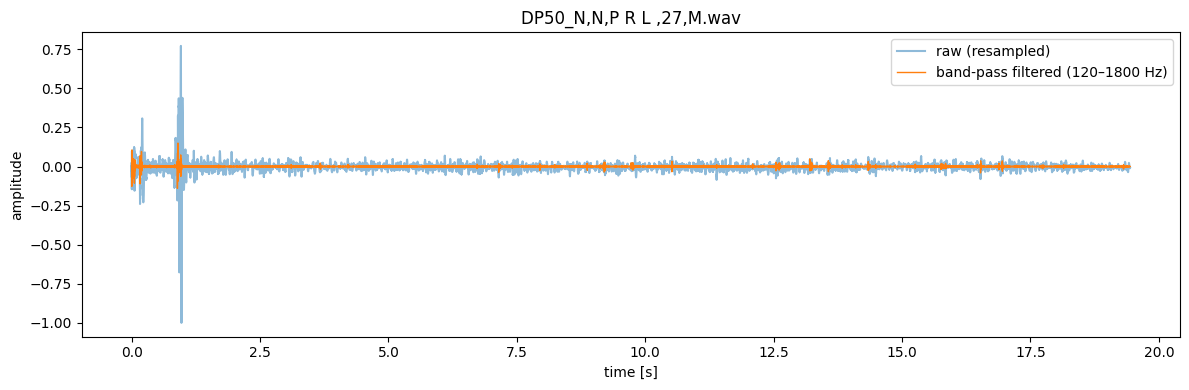

In [59]:
# pick a random file and plot waveform (original + filtered)
rng = np.random.default_rng(0)

if len(df_ka_files) > 0:
    sample_row = df_ka_files.sample(n=1, random_state=rng.integers(0, 1_000_000)).iloc[0]
    sample_path = Path(sample_row["path"])
    print("random file:", sample_path.name)
    print("diagnosis :", sample_row["diagnosis"])
    print("location  :", sample_row["location"])
    print("filter    :", sample_row["filter_type"])

    y, sr = load_and_resample_mono(sample_path, target_sr=TARGET_SR)
    y_filt = butter_bandpass_filter(y, sr=sr)

    t = np.arange(len(y)) / sr

    plt.figure(figsize=(12, 4))
    plt.plot(t, y, alpha=0.5, label="raw (resampled)")
    plt.plot(t, y_filt, linewidth=1.0, label="band-pass filtered (120–1800 Hz)")
    plt.xlabel("time [s]")
    plt.ylabel("amplitude")
    plt.title(sample_path.name)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("no files found in AUDIO_DIR, cannot plot.")


In [62]:
def process_single_ka_recording(
    audio_path: Path,
    sr_target: int = TARGET_SR,
    window_length_sec: float = WINDOW_LENGTH_SEC,
    step_size_sec: float = STEP_SIZE_SEC,
) -> Tuple[List[np.ndarray], List[float], List[float]]:
    """
    load, resample, band-pass filter and segment a single ka recording.

    returns
    -------
    segments : list of np.ndarray
    start_times : list of float
    end_times : list of float
    """
    y, sr = load_and_resample_mono(audio_path, target_sr=sr_target)
    assert sr == sr_target, f"unexpected sr for {audio_path}: {sr}"

    y_filt = butter_bandpass_filter(
        y,
        sr=sr,
        low_hz=LOW_CUT_HZ,
        high_hz=HIGH_CUT_HZ,
        order=FILTER_ORDER,
    )

    segments, start_times, end_times = segment_signal(
        y_filt,
        sr=sr,
        window_length_sec=window_length_sec,
        step_size_sec=step_size_sec,
    )

    if segments:
        win_samples = int(round(window_length_sec * sr))
        assert all(seg.shape[0] == win_samples for seg in segments)

    return segments, start_times, end_times


In [63]:
# quick test on the same random file as above
test_segments, test_t0, test_t1 = process_single_ka_recording(sample_path)
print(f"segments from {sample_path.name}:", len(test_segments))
print("first segment shape:", test_segments[0].shape if test_segments else None)
print("first segment time:", test_t0[0], "→", test_t1[0] if test_t0 else None)


segments from DP50_N,N,P R L ,27,M.wav: 17
first segment shape: (10000,)
first segment time: 0.0 → 2.5


In [64]:
def process_ka_dataset_from_df(
    df_files: pd.DataFrame,
) -> Tuple[List[np.ndarray], pd.DataFrame]:
    """
    process the ka dataset into fixed-length segments and per-segment metadata.

    df_files should contain at least:
        file_name, path, patient_id, diagnosis,
        location, filter_type

    returns
    -------
    segments : list of np.ndarray
        all segments from all recordings (2.5 s at 4 kHz).
    meta_segments : pd.DataFrame
        columns:
            dataset
            subject_id
            recording_id
            segment_id
            start_time
            end_time
            location
            acoustic_label
            diagnosis_label
            filter_type
    """
    required_cols = ["file_name", "path", "patient_id", "diagnosis", "location", "filter_type"]
    missing = [c for c in required_cols if c not in df_files.columns]
    if missing:
        raise ValueError(f"df_files missing required columns: {missing}")

    all_segments: List[np.ndarray] = []
    rows: list[dict] = []
    global_segment_id = 0

    for _, row in df_files.iterrows():
        audio_path = Path(row["path"])
        if not audio_path.is_file():
            print(f"[warn] audio file not found: {audio_path}")
            continue

        subject_id = str(row["patient_id"])
        diagnosis_label = row["diagnosis"]
        location = row["location"]
        filter_type = row["filter_type"]
        recording_id = Path(row["file_name"]).stem

        segments, start_times, end_times = process_single_ka_recording(audio_path)

        for seg, t_start, t_end in zip(segments, start_times, end_times):
            all_segments.append(seg)
            rows.append(
                {
                    "dataset": "KA",
                    "subject_id": subject_id,
                    "recording_id": recording_id,
                    "segment_id": global_segment_id,
                    "start_time": float(t_start),
                    "end_time": float(t_end),
                    "location": location,
                    # acoustic_label = diagnosis for now
                    "acoustic_label": diagnosis_label,
                    "diagnosis_label": diagnosis_label,
                    "filter_type": filter_type,
                }
            )
            global_segment_id += 1

    meta_segments = pd.DataFrame(rows)

    if len(all_segments) > 0:
        expected_len = int(round(WINDOW_LENGTH_SEC * TARGET_SR))
        assert all(
            isinstance(seg, np.ndarray)
            and seg.ndim == 1
            and seg.shape[0] == expected_len
            for seg in all_segments
        ), "not all segments have expected shape"

    needed_cols = [
        "dataset",
        "subject_id",
        "recording_id",
        "segment_id",
        "start_time",
        "end_time",
        "location",
        "acoustic_label",
        "diagnosis_label",
        "filter_type",
    ]
    missing_meta = [c for c in needed_cols if c not in meta_segments.columns]
    assert not missing_meta, f"missing metadata columns: {missing_meta}"
    assert len(all_segments) == len(meta_segments), "segment count mismatch"

    return all_segments, meta_segments


In [65]:
ka_segments, ka_meta = process_ka_dataset_from_df(df_ka_files)
print("total KA segments:", len(ka_segments))
ka_meta.head()


total KA segments: 5174


,dataset,subject_id,recording_id,segment_id,start_time,end_time,location,acoustic_label,diagnosis_label,filter_type
0,KA,P100,"BP100_N,N,P R M,70,F",0,0.0,2.5,prm,n,n,B
1,KA,P100,"BP100_N,N,P R M,70,F",1,1.0,3.5,prm,n,n,B
2,KA,P100,"BP100_N,N,P R M,70,F",2,2.0,4.5,prm,n,n,B
3,KA,P100,"BP100_N,N,P R M,70,F",3,3.0,5.5,prm,n,n,B
4,KA,P100,"BP100_N,N,P R M,70,F",4,4.0,6.5,prm,n,n,B


In [71]:
def plot_waveform_with_segments(
    y: np.ndarray,
    sr: int,
    start_times: list[float],
    end_times: list[float],
    title: str = None,
    color=(0.6, 0.8, 1.0, 0.25),  # light blue transparent overlay
):
    """
    plot waveform with segmentation windows overlaid in a single consistent color.
    best option for KA dataset (no cycle labels).
    """
    y = np.asarray(y).reshape(-1)
    t = np.arange(len(y)) / sr

    fig, ax = plt.subplots(figsize=(12, 3))

    # draw waveform
    ax.plot(t, y, linewidth=0.8, color="C0")

    ymin, ymax = ax.get_ylim()

    # draw EVERY segment in the same color block
    for t0, t1 in zip(start_times, end_times):
        ax.add_patch(
            Rectangle(
                (t0, ymin),
                width=t1 - t0,
                height=ymax - ymin,
                facecolor=color,
                edgecolor=None,
                linewidth=0,
            )
        )

    # redraw waveform on top for visibility
    ax.plot(t, y, linewidth=0.8, color="C0")

    ax.set_xlim(t[0], t[-1])
    ax.set_xlabel("time [s]")
    ax.set_ylabel("amplitude")
    if title:
        ax.set_title(title)

    plt.tight_layout()
    plt.show()


In [72]:
sample_path = Path(sample_row["path"])
y, sr = load_and_resample_mono(sample_path, target_sr=TARGET_SR)
y_filt = butter_bandpass_filter(y, sr=sr)

segments, start_times, end_times = segment_signal(
    y_filt,
    sr=sr,
    window_length_sec=WINDOW_LENGTH_SEC,
    step_size_sec=STEP_SIZE_SEC,
)


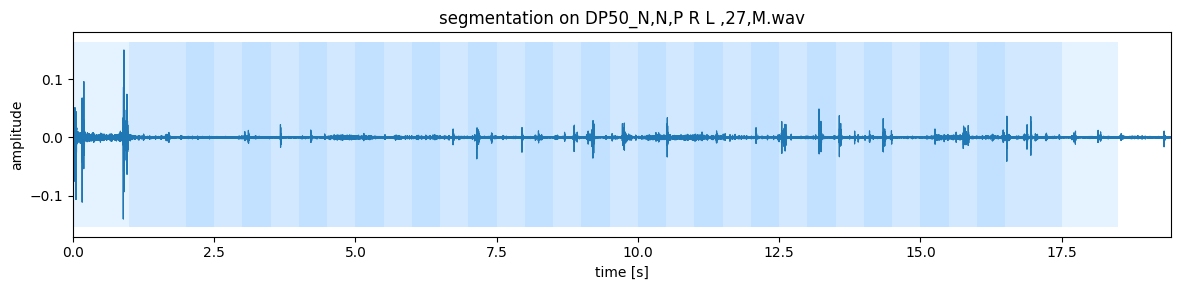

In [73]:
# simple version: no per-segment label
plot_waveform_with_segments(
    y=y_filt,
    sr=sr,
    start_times=start_times,
    end_times=end_times,
    title=f"segmentation on {sample_path.name}",
)
